In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [6]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
img_width = 150
img_height = 150

epochs = 50
batch_size = 16

train_data_dir = "train"  
validation_data_dir = "validation"
test_data_dir = "test"

nb_train_samples = 3000
nb_validation_samples = 1000

In [4]:
import time

ti_bn_features = time.time()

model = InceptionV3(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

'''
https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L1002
if PIL version 1.1.3 interpolation = 'lanczos'
else interpolation = 'bicubic' 
''' 

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False)

nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 

bnfeatures_train = model.predict_generator(
    generator, predict_size_train)

np.save('../data/output_convnet/inception_bnfeatures_train.npy', bnfeatures_train)


generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_validation_samples = len(generator.filenames)
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bnfeatures_val = model.predict_generator(  
     generator, predict_size_validation)

np.save('../data/output_convnet/inception_bnfeatures_val.npy', bnfeatures_val)


tf_bn_features = time.time()    
tt_bn_features = tf_bn_features - ti_bn_features
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
00:00:26


Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 2s 506us/step - loss: 1.6494 - acc: 0.4043 - val_loss: 1.3851 - val_acc: 0.5640
Epoch 2/50
3000/3000 [==============================] - 1s 314us/step - loss: 1.2265 - acc: 0.6750 - val_loss: 1.1575 - val_acc: 0.7240
Epoch 3/50
3000/3000 [==============================] - 1s 299us/step - loss: 1.0379 - acc: 0.7650 - val_loss: 1.0248 - val_acc: 0.7540
Epoch 4/50
3000/3000 [==============================] - 1s 305us/step - loss: 0.9147 - acc: 0.7940 - val_loss: 0.9295 - val_acc: 0.7720
Epoch 5/50
3000/3000 [==============================] - 1s 316us/step - loss: 0.8254 - acc: 0.8100 - val_loss: 0.8681 - val_acc: 0.7700
Epoch 6/50
3000/3000 [==============================] - 1s 308us/step - loss: 0.7592 - acc: 0.8210 - val_loss: 0.8125 - val_acc: 0.7870
Epoch 7/50
3000/3000 [==============================

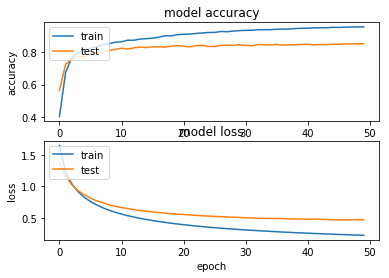

00:00:48


In [9]:
import os

ti_bn_train = time.time()

datagen_top = ImageDataGenerator(rescale=1./255)  

generator_top = datagen_top.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    interpolation = 'lanczos')  

nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  


train_data = np.load('../data/output_convnet/inception_bnfeatures_train.npy')

# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  

# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)



generator_top = datagen_top.flow_from_directory(  
    validation_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False,
    interpolation = 'lanczos')  

nb_validation_samples = len(generator_top.filenames)  

validation_data = np.load('../data/output_convnet/inception_bnfeatures_val.npy')  

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

# top model
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=SGD(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy']) 

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))  

model.save_weights('../data/output_convnet/bn_inception_model.h5')  

(eval_loss, eval_accuracy) = model.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print()
print()
print("acc: {:.2f}%".format(eval_accuracy * 100))  
print("loss: {}".format(eval_loss))

plt.figure(1)  
   
# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

PATH_TO_OUTPUT = "../data/output_convnet"
plt.savefig(os.path.join(PATH_TO_OUTPUT, "bn_inception.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

tf_bn_train = time.time()    
tt_bn_train = tf_bn_train - ti_bn_train
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

In [11]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/bn_inception_model.h5', mode='r')
print(list(hdf5_file))

['dense_1', 'dense_2', 'global_average_pooling2d_2']


In [13]:
top_model_weights_path = '../data/output_convnet/bn_inception_model.h5'

batch_size = 5 # con 5 funciona con 16 es imposible probar con 10

In [15]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input

In [16]:
input_tensor = Input(shape=(img_width,img_height,3))
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
print("model loaded")

model loaded


In [17]:
base_model.output_shape[1:]

(3, 3, 2048)

In [19]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(num_classes, activation='softmax'))

In [28]:
# for i, layer in enumerate(base_model.layers):
#     print (i, layer.name, layer.output_shape)

In [21]:
for i, layer in enumerate(top_model.layers):
    print (i, layer.name, layer.output_shape)

0 global_average_pooling2d_4 (None, 2048)
1 dense_3 (None, 1024)
2 dense_4 (None, 8)


In [22]:
top_model.load_weights("../data/output_convnet/bn_inception_model.h5")

In [23]:
model_total = Model(input= base_model.input, output= top_model(base_model.output))

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [33]:
for layer in model_total.layers[:280]:
    layer.trainable = False
for layer in model_total.layers[280:]:
    layer.trainable = True

In [34]:
# for i, layer in enumerate(model_total.layers):
#     if layer.trainable:
#         print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
#     else:
#         print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_2 is freezed
layer 1, conv2d_95 is freezed
layer 2, batch_normalization_95 is freezed
layer 3, activation_95 is freezed
layer 4, conv2d_96 is freezed
layer 5, batch_normalization_96 is freezed
layer 6, activation_96 is freezed
layer 7, conv2d_97 is freezed
layer 8, batch_normalization_97 is freezed
layer 9, activation_97 is freezed
layer 10, max_pooling2d_5 is freezed
layer 11, conv2d_98 is freezed
layer 12, batch_normalization_98 is freezed
layer 13, activation_98 is freezed
layer 14, conv2d_99 is freezed
layer 15, batch_normalization_99 is freezed
layer 16, activation_99 is freezed
layer 17, max_pooling2d_6 is freezed
layer 18, conv2d_103 is freezed
layer 19, batch_normalization_103 is freezed
layer 20, activation_103 is freezed
layer 21, conv2d_101 is freezed
layer 22, conv2d_104 is freezed
layer 23, batch_normalization_101 is freezed
layer 24, batch_normalization_104 is freezed
layer 25, activation_101 is freezed
layer 26, activation_104 is freezed
layer 27, average_

In [35]:
model_total.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy']) 

In [36]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [ ]:
import time
# fine-tune the model

# añadir medidas de acc loss como el bottleneck

ti_ftuning = time.time()


historical_data = model_total.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    verbose = 1,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples)

tf_ftuning = time.time()
tt_ftuning = tf_ftuning - ti_ftuning
print(time.strftime("%H:%M:%S", time.gmtime(tt_ftuning)))

In [ ]:
import matplotlib.pyplot as plt
PATH_TO_DF = "../data/output_convnet"

acc = historical_data.history['acc']
val_acc = historical_data.history['val_acc']
loss = historical_data.history['loss']
val_loss = historical_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_total.save_weights('../data/output_convnet/ft_inception_model.h5')

In [ ]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/ft_inception_model.h5', mode='r')
print(list(hdf5_file))

In [ ]:
# build the VGG16 network
# input_tensor = Input(shape=(img_width,img_height,3))
model_base_pred = IncetionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)  
print("model base for predition loaded")

# build top model  
top_model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(num_classes, activation='softmax'))
print()
print("model top for predition loaded")

In [ ]:
model_total_pred = Model(input= model_base_pred.input, output= model_top_pred(model_base_pred.output))

In [ ]:
# for i, layer in enumerate(model_total_pred.layers):
#     print (i, layer.name, layer.output_shape)

In [ ]:
# cargamos los pesos anteriormente obtenidos en el entrenamiento
model_total_pred.load_weights("../data/output_convnet/ft_inception_model.h5")

In [ ]:
test_data_dir = 'test/'
batch_size_test = 5 # probamos con esto

test_convnet = ImageDataGenerator(rescale=1. / 255)

test_generator = test_convnet.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle =False,
    class_mode='categorical')

cat_dict = test_generator.class_indices

inverse_coding = {v: k for k, v in cat_dict.items()}

In [ ]:
import os

test_data_dir = "test/"

# listado del train
img_test_real = [] # listado de las imagenes pareado con img_cat_real
img_cat_real = [] # categorias de las imagenes


img_cat_pred = [] # elementos predichos por la convnet

img_folder = sorted([folder for folder in os.listdir(test_data_dir)
                  if os.path.isdir(os.path.join(test_data_dir, folder))])

for index_folder, category in enumerate(img_folder):
    
    folder = os.path.join(test_data_dir, category)

    for index_img, img in enumerate(os.listdir(folder)):
        
        if img.endswith(".tif"): # just in case there are other kind of files like .db
            img_test_real.append(os.path.join(folder, img))
            img_cat_real.append(img_folder[index_folder])

    print("Category {0:s} has {1:d} images.".format(category, index_img+1))

In [ ]:
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input

In [ ]:
for index, img_path in enumerate(img_test_real):
    
    index += 1
    
    if not index % 100:
        print("image {0:d} processed".format(index))
        
    # pre process
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    x = x / 255
    
    # prediction
    x = model_total_pred.predict(x)
    
    # label
    label = inverse_coding[np.argmax(x)]
    
    # store the label
    img_cat_pred.append(label)
    

In [ ]:
img_cat_pred_arr = np.array(img_cat_pred)
img_cat_real_arr = np.array(img_cat_real)

In [ ]:
from sklearn.metrics import confusion_matrix
ft_conf_mat = confusion_matrix(img_cat_real_arr,img_cat_pred_arr)

In [ ]:
ft_conf_mat

In [ ]:
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)

In [ ]:
PATH_TO_IMG = "../data/input_dataset"
class_names = sorted([folder for folder in os.listdir(PATH_TO_IMG)
                      if os.path.isdir(os.path.join(PATH_TO_IMG, folder))])

In [ ]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plot_confusion_matrix(ft_conf_mat, classes=class_names, title='Confusion matrix')

fig.add_subplot(1,2,2)
plot_confusion_matrix(ft_conf_mat, classes=class_names, normalize=True, title='Confusion matrix')

plt.savefig(os.path.join(PATH_TO_DF, "ft_confmat_VGG16.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# print(classification_report(y_test, pred_categorical))
# print("The total accuracy is", accuracy_score(y_test, pred_categorical))